In [133]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Import

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [135]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [136]:
from catboost import CatBoostClassifier 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [137]:
np.random.seed(42)

# To DataFrame

In [138]:
list_file = []

for dirname, _, filenames in os.walk('/kaggle/input/spaceship-titanic'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        list_file.append(file_path)
print(list_file)

['/kaggle/input/spaceship-titanic/sample_submission.csv', '/kaggle/input/spaceship-titanic/train.csv', '/kaggle/input/spaceship-titanic/test.csv']


In [139]:
sample_root = pd.read_csv(list_file[0])
train_root = pd.read_csv(list_file[1])
test_root = pd.read_csv(list_file[2])

len(sample_root), len(train_root), len(test_root)

(4277, 8693, 4277)

In [140]:
train_root.head(5).style.background_gradient(cmap='coolwarm')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000000,False,109.000000,9.000000,25.000000,549.000000,44.000000,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000000,True,43.000000,3576.000000,0.000000,6715.000000,49.000000,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000000,False,0.000000,1283.000000,371.000000,3329.000000,193.000000,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000000,False,303.000000,70.000000,151.000000,565.000000,2.000000,Willy Santantines,True


In [141]:
train_root.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [142]:
train = train_root.dropna()
train.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

# EDA

In [143]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,6606.0,28.894036,14.533429,0.0,19.0,27.0,38.00,79.0
RoomService,6606.0,222.991674,644.987936,0.0,0.0,0.0,49.00,9920.0
FoodCourt,6606.0,478.958523,1678.592291,0.0,0.0,0.0,82.75,29813.0
ShoppingMall,6606.0,178.356494,576.328407,0.0,0.0,0.0,30.00,12253.0
Spa,6606.0,313.161520,1144.016291,0.0,0.0,0.0,65.00,22408.0
VRDeck,6606.0,303.780048,1127.142166,0.0,0.0,0.0,52.00,20336.0


In [144]:
numerical_df = train[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
numerical_df

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0
8689,18.0,0.0,0.0,0.0,0.0,0.0
8690,26.0,0.0,0.0,1872.0,1.0,0.0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

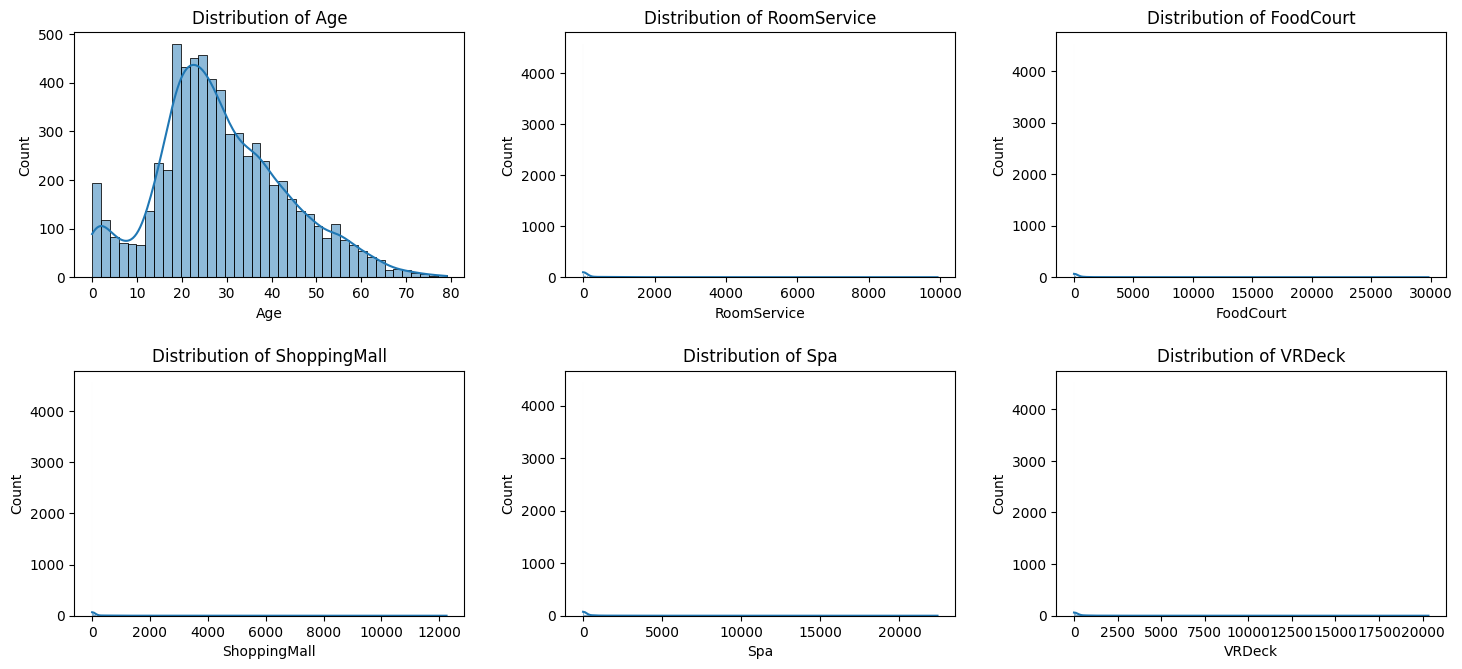

In [145]:
plt.figure(figsize=(15, 10))

num_vars = len(numerical_df.columns)

for i, var in enumerate(numerical_df.columns, 1):
    plt.subplot((num_vars // 3) + 1, 3, i)
    sns.histplot(data=train, x=var, kde=True)
    plt.title(f'Distribution of {var}')

plt.tight_layout(pad=2.0)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


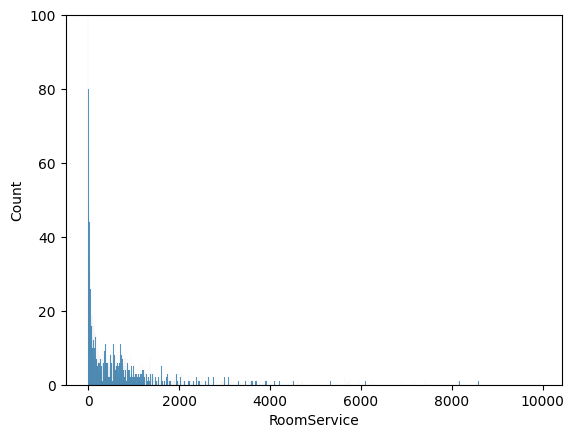

In [146]:
sns.histplot(data=train['RoomService'])
plt.ylim(0, 100)  
plt.yticks(range(0, 101, 20))  
plt.show()

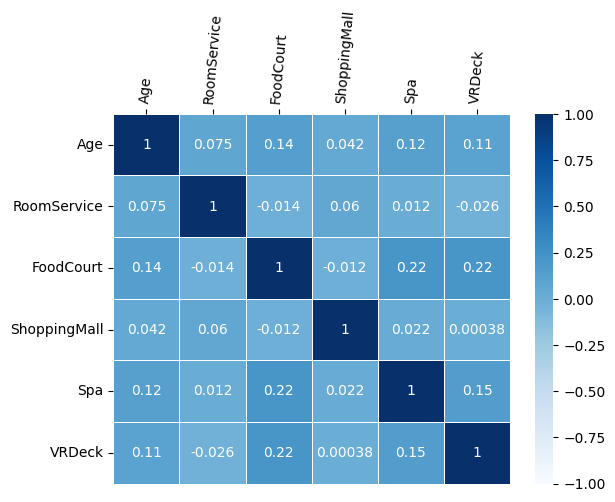

In [147]:
ax = sns.heatmap(numerical_df.corr(), vmin=-1, vmax=1, annot=True, cmap="Blues", linewidth=.5)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.xticks(rotation = 85)
plt.show()

# Preprocessing

In [148]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [149]:
x = train.drop(['PassengerId', 'Name', 'Transported'], axis=1)
x

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0
8689,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0
8690,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0
8691,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0


In [150]:
y = train['Transported']

In [151]:
y_cl = y.astype(str).str.strip().str.lower()
y_bi = y_cl.map({'false': 0, 'true': 1})
y_bi

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Name: Transported, Length: 6606, dtype: int64

In [152]:
categorical_name = x[['HomePlanet', 'CryoSleep', 'Cabin','Destination', 'VIP']]
numerical_name = x[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]

In [153]:
x.shape, y.shape

((6606, 11), (6606,))

In [154]:
X_train, X_val, y_train, y_val = train_test_split(x, y_bi, test_size=0.1, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((5945, 11), (5945,), (661, 11), (661,))

In [155]:
X_test = test_root.drop(columns=["PassengerId","Name"], axis=1)
X_test.shape

(4277, 11)

In [156]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']),
        ('num', MinMaxScaler(), ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])
    ]
)

In [157]:
x_train2 = preprocessor.fit_transform(X_train)
x_val2 = preprocessor.transform(X_val)
x_test2 = preprocessor.transform(X_test)

In [158]:
x_val2.shape, y_val.shape

((661, 4887), (661,))

In [159]:
x_train2.shape, y_train.shape

((5945, 4887), (5945,))

In [160]:
x_test2.shape

(4277, 4887)

# Modeling

In [161]:
assert x_train2.shape[1] == x_val2.shape[1] == x_test2.shape[1], \
    f"Mismatch in feature dimensions! Got: {x_train2.shape[1]}, {x_val2.shape[1]}, {x_test2.shape[1]}"

In [162]:
model = CatBoostClassifier(iterations=700, depth=7, learning_rate=0.1, verbose=0)  # Removed cat_features
model.fit(x_train2, y_train)

# Evaluation

In [163]:
y_train_pred = model.predict(x_train2)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))

y_val_pred = model.predict(x_val2)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

Train Accuracy: 0.8289318755256518
Validation Accuracy: 0.8335854765506808

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       321
           1       0.82      0.87      0.84       340

    accuracy                           0.83       661
   macro avg       0.84      0.83      0.83       661
weighted avg       0.83      0.83      0.83       661



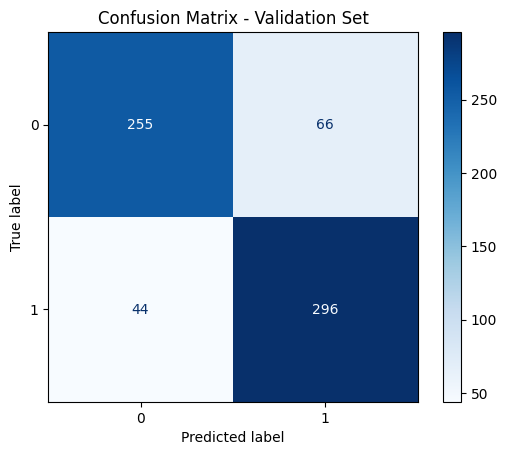

In [164]:
y_val_pred = model.predict(x_val2)

cm = confusion_matrix(y_val, y_val_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Validation Set")
plt.show()

# Submission

In [165]:
y_pred_test = model.predict(x_test2)

In [166]:
y_pred_test.shape

(4277,)

In [167]:
submission = pd.DataFrame({
    'PassengerId': test_root['PassengerId'],
    'Transported': y_pred_test
})

In [168]:
submission['Transported'] = submission['Transported'].astype(bool)

In [169]:
submission.to_csv(os.path.join('/kaggle/working', 'submission.csv'), index=False)